 # <h1><center><strong style="color:#ff6161"> Detecting Linux System Hacking Activities </center></strong></h3>
 

## 1. Data preparation and exploration (35%)


### 1.1 Creating Spark Session (4%)

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Detecting Hacking Activities"
#sc.stop()
# Changing the max partition byte configuration to minimum of 2 partitions when readin the file
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes", 33554432).set("spark.driver.memory", "6g").set("spark.executor.memory","6g")

# Import SparkContext and SparkSession classes  .set("spark.sql.shuffle.partitions",100)
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# # Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

## 1.2 Loading the data (16%)

In [2]:
## Loading each activity data into a Spark dataframe and caching the data

#Using the specified below schema to load the data to compile the schema

from pyspark.sql.types import StructType, IntegerType, DateType
from pyspark.sql.types import *

#Custom schema for memory activity

#Importing some columns as string data type for further transformation 

customSchema_memory = StructType([
    StructField("ts", IntegerType(), True),        
    StructField("PID", IntegerType(), True),
    StructField("MINFLT", StringType(), True),
    StructField("MAJFLT", StringType(), True),
    StructField("VSEXT", StringType(), True),
    StructField("VSIZE", DoubleType(), True),
    StructField("RSIZE", StringType(), True),
    StructField("VGROW", StringType(), True),
    StructField("RGROW", StringType(), True),
    StructField("MEM", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", IntegerType(), True),
    StructField("type", StringType(), True)
])

In [3]:
# Reading the Linux memory csv's in a dataframe and caching it
memoryDF_load = spark.read.csv('linux_memory_*.csv', header=True, schema=customSchema_memory).cache()

In [4]:
#Counting the number of records
memoryDF_load.count()

2000000

In [5]:
#Checking the number of partition created for the dataframe
memoryDF_load.rdd.getNumPartitions()

4

In [4]:
# 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW','RGROW' these columns have a number data type and so now 
# it needs to be converted appropriately.

# As some of the schema is not in sync with the relevant schema mentioned in the metadata file and they need to transformed next

from pyspark.sql.functions import *
from pyspark.sql import Row
import pyspark.sql.functions as f


#Replacing the fields which include K, M With the corresponding numeric values of 10^3 and 10^6 
memoryDF = memoryDF_load.withColumn('MINFLT', regexp_replace('MINFLT', 'K', '000'))
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', 'K', '000'))
memoryDF = memoryDF.withColumn('VSEXT', regexp_replace('VSEXT', 'K', '000'))
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', 'K', '000'))
memoryDF = memoryDF.withColumn('VGROW', regexp_replace('VGROW', 'K', '000'))
memoryDF = memoryDF.withColumn('RGROW', regexp_replace('RGROW', 'K', '000'))

# Values with decimal converted to correctly represent the value 
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', '.2M', '200000')) 
memoryDF = memoryDF.withColumn('MAJFLT', regexp_replace('MAJFLT', '.4M', '400000'))
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', '.2M', '200000')) 
memoryDF = memoryDF.withColumn('RSIZE', regexp_replace('RSIZE', '.4M', '400000'))

#Removing the space in between some values
memoryDF = memoryDF.withColumn('VGROW', regexp_replace('VGROW', ' ', ''))
memoryDF = memoryDF.withColumn('RGROW', regexp_replace('RGROW', ' ', ''))



In [5]:
#Casting the data to the required schema from the metadata

memoryDF = memoryDF.withColumn("MINFLT", f.col("MINFLT").cast('int'))
memoryDF = memoryDF.withColumn("MAJFLT", f.col("MAJFLT").cast('double'))
memoryDF = memoryDF.withColumn("VSEXT", f.col("VSEXT").cast('double'))
memoryDF = memoryDF.withColumn("RSIZE", f.col("RSIZE").cast('double'))
memoryDF = memoryDF.withColumn("VGROW", f.col("VGROW").cast('double'))
memoryDF = memoryDF.withColumn("RGROW", f.col("RGROW").cast('double'))

In [8]:
# Checking for null values in the data
from pyspark.sql.functions import isnan, when, count, col
memoryDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in memoryDF.columns]).show() 

+---+---+------+------+-----+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+-----+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|    0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+-----+-----+-----+-----+-----+---+---+------+----+



In [9]:
#Required schema for the Memory Dataframe
memoryDF.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



### Loading the Linux Process Activity Data 

In [4]:
#Using the specified below schema to load the data to compile the schema
customSchema_process = StructType([
    StructField("ts", LongType(), True),        
    StructField("PID", IntegerType(), True),
    StructField("TRUN", IntegerType(), True),
    StructField("TSLPI", IntegerType(), True),
    StructField("TSLPU", IntegerType(), True),
    StructField("POLI", StringType(), True),
    StructField("NICE", IntegerType(), True),
    StructField("PRI", IntegerType(), True),
    StructField("RTPR", IntegerType(), True),
    StructField("CPUNR", IntegerType(), True),
    StructField("Status", StringType(), True),
    StructField("EXC", IntegerType(), True),
    StructField("State", StringType(), True),
    StructField("CPU", DoubleType(), True),
    StructField("CMD", StringType(), True),
    StructField("attack", IntegerType(), True),
    StructField("type", StringType(), True)
])

In [5]:
#Reading the Linux process csv's in a dataframe
processDF = spark.read.csv('linux_process_*.csv', header=True, schema=customSchema_process)

In [6]:
df_process_formatted_pp = processDF

In [8]:
from pyspark.sql.functions import *
# 120
# 100
# 130
# 121
# 109
# 139
# 0

from pyspark.sql.types import *

df_process_formatted = df_process_formatted_pp.withColumn("NICE", when((col("PRI") == 100), -20)\
                                                      .when((col("PRI") == 109),-11)\
                                                       .when((col("PRI") == 120),0)\
                                                      .when((col("PRI") == 121),1)\
                                                      .when((col("PRI") == 130),10)\
                                                      .when((col("PRI") == 139),19)\
                                                      .otherwise(0))

In [13]:
df_process_formatted.groupBy('PRI', 'NICE').count().show()

+---+----+-------+
|PRI|NICE|  count|
+---+----+-------+
|130|  10|   1586|
|121|   1|  16840|
|120|   0|1394954|
|  0|   0|  66410|
|109| -11|   6765|
|139|  19|    116|
|110|   0|     15|
|100| -20| 441282|
+---+----+-------+



In [10]:
from pyspark.sql import functions as F
df_process_formatted_pp.select(df_process_formatted_pp.NICE, F.when(df_process_formatted_pp.NICE - df_process_formatted_pp.PRI != 120, 120-df_process_formatted_pp.PRI).otherwise(0)).show()

#df_process_formatted_pp.select(df_process_formatted_pp.NICE, F.when(df_process_formatted_pp.NICE - df_process_formatted_pp.PRI != 120, 120-df_process_formatted_pp.PRI).otherwise(0)).show()

df_process_formatted_pp.withColumn("NICE", when(((col("NICE") - (col("PRI")) != 120 )),(120+(col("PRI"))).otherwise(col("NICE")).show())

SyntaxError: unexpected EOF while parsing (<ipython-input-10-b413c94ca589>, line 6)

In [12]:
#Counting the number of records
processDF.count()

1927968

In [13]:
#Checking the number of partition created for the dbataframe
processDF.rdd.getNumPartitions()

4

In [14]:
#Checking for any nulls in the data

from pyspark.sql.functions import isnan, when, count, col
processDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in processDF.columns]).show()


+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



## Exploring the data (15%)

### 1. Show the count of attack and non-attack in each activity based on the column “attack”, then show the count of each kind of attack in process activity based on the column “type”.

In [15]:
#Checking the count of attacks and non-attacks
memoryDF.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 205623|
|     0|1794377|
+------+-------+



In [16]:
#Checking the count of attacks and non-attacks
processDF.groupBy('attack').count().show()

+------+-------+
|attack|  count|
+------+-------+
|     1| 291364|
|     0|1636604|
+------+-------+



In [17]:
# Counting each kind of attack in process activity
processDF.groupBy('type').count().show()

+---------+-------+
|     type|  count|
+---------+-------+
|      xss|  17759|
| password|  51409|
| scanning|  38449|
|     ddos|  71603|
|   normal|1636604|
|     mitm|    112|
|injection|  41311|
|      dos|  70721|
+---------+-------+



<p><strong style="color:#2a52be"> From the above count distribution we can see that, all the normal type of attacks come under the non attack type i.e harmless attacks. 

The total attacks count is only one eighth of that of the non attacks count for Linux memory data. While for process activity the attacks count is one fifth of the non attacks count. The maximum attack count is for the DDoS attack type, followed by DoS and password. The least attack type is accounted for MitM. 
    
</strong>

### 2.  For each numeric feature in each activity, show the basic statistics (including count, mean, stddev, min, max); for each non-numeric feature in each activity, display the top-10 values and the corresponding counts.

<p><strong style="color:#2a52be"> Displaying the statistics for numeric columns in Memory Activity:  </strong>

In [18]:
memoryDF.select('ts','PID','MINFLT','MAJFLT','VSEXT','VSIZE','RSIZE','VGROW','RGROW','MEM').describe().toPandas().head()

,summary,ts,PID,MINFLT,MAJFLT,VSEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.5873270865,46453.27415208986,4496.419966448755,23722.888664201997,984.4668735599995,483.17466254999994,0.003385165000001682
2,stddev,984463.3682899477,4887.313351921473,19229.610980642334,1.4842874238098994E7,658730.2051543018,9046.338093399043,1986383.1808735211,86174.82585202329,1491.4761059171788,0.010943425779985876
3,min,1554216855,1007,0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


<p><strong style="color:#2a52be"> As seen, from the statistics there is a wide range of values for most of the columns based on min and max stats.    </strong>

<p><strong style="color:#2a52be"> Displaying the top-10 values for non-numeric columns in Memory Activity:  </strong>

In [19]:
memoryDF.groupBy('CMD').count().sort('count',ascending=False).limit(10).show()

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+



<p><strong style="color:#2a52be"> Displaying the statistics for numeric columns in Process Activity: </strong>

In [20]:
processDF.select('ts','PID','TRUN','TSLPI','NICE','PRI','RTPR','CPUNR','EXC','CPU').describe().toPandas().head()

,summary,ts,PID,TRUN,TSLPI,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299209388
2,stddev,771350.0248109627,4987.784329320437,0.247825870904161,6.988459728531793,8.40318986475207,22.624445062102893,0.0,1.5274047225903056,1.4619498567691878,0.13628943687184275
3,min,1554216855,1007,0,0,0,0,0,0,0,0.0
4,max,1557593017,53080,12,70,20,139,0,5,127,4.02


<p><strong style="color:#2a52be"> Based on the statistics, most of the data has a low range of varied values, from Min and max stats except ts.   </strong>

<p><strong style="color:#2a52be"> Displaying the top-10 values for non-numeric columns in Process Activity: </strong>

In [21]:
processDF.groupBy('POLI').count().sort('count',ascending=False).limit(10).show()

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+



In [22]:
processDF.groupBy('Status').count().sort('count',ascending=False).limit(10).show()

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+



In [23]:
processDF.groupBy('State').count().sort('count',ascending=False).limit(10).show()

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+



In [24]:
processDF.groupBy('CMD').count().sort('count',ascending=False).limit(10).show()

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+



### 3. For each activity, present two plots worthy of presenting to the StopHacking company, describe your plots and discuss the findings from the plots

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

<p><strong style="color:#2a52be"> Downsampling the Memory Data to visualize the plots: </strong>

In [10]:
memoryDF_Sample = memoryDF.select('ts','PID','MINFLT','MAJFLT','VSEXT','VSIZE','RSIZE','VGROW','RGROW','MEM','attack').cache()
memoryDF_Sample = memoryDF_Sample.toPandas()

<p><strong style="color:#2a52be"> Downsampling the Process Data to visualize the plots: </strong>

In [7]:
processDF_Sample_Num = processDF.select('ts','PID','TRUN','TSLPI','TSLPU','NICE','PRI','CPUNR','EXC','CPU','attack').cache()
processDF_Sample_Num = processDF_Sample_Num.toPandas()

#### Pair plotting the two columns from Memory Data : (ts vs Attack) & (type & Attack)

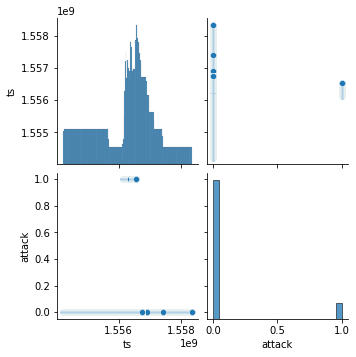

In [10]:
import seaborn as sns
cols = ['ts','attack']
sns.pairplot(memoryDF_Sample[cols])

<p><strong style="color:#2a52be"> The attacks seem to be between the 1.556 and 1.557 timestamp. And majority of the non-attacks i.e the normal processes appear over all the timestamp duration. But the attacks seem to be concentrated within the timestamp duration of 1.556 and 1.557. </strong>

<AxesSubplot:xlabel='type'>

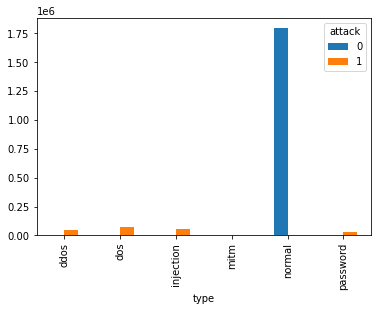

In [11]:
memory_Sample = memoryDF.select('attack','type')
memory_Sample = memory_Sample.toPandas()

memory_type_grouped = memory_Sample.groupby(["type", "attack"]).size().reset_index(name='Count')
memory_plot = pd.pivot_table(memory_type_grouped,  values='Count',  columns=['attack'],  index = "type")
memory_plot.plot(kind="bar")

<p><strong style="color:#2a52be"> As seen in the graph above, the normal processes are seen to be maximum, with the attack events less than 2L for each type. The maximum attack type seen here is the dos attack. And the minimum attack type is for mitm. </strong>

<AxesSubplot:xlabel='type'>

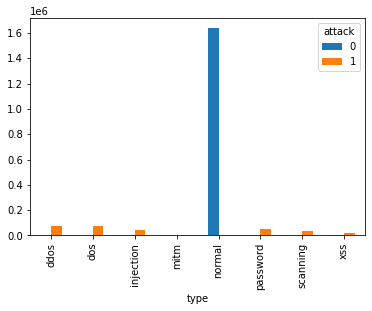

In [8]:
process_Sample = processDF.select(['attack','type'])
process_Sample = process_Sample.toPandas()

process_type_grouped = process_Sample.groupby(["type", "attack"]).size().reset_index(name='Count')
process_plot = pd.pivot_table(process_type_grouped,  values='Count',  columns=['attack'],  index = "type")
process_plot.plot(kind="bar")

<p><strong style="color:#2a52be"> As seen in the graph above, the normal process are seen to be maximum, with the attack events less than 2L for each type. The maximum attack type seen here is thw ddos attack. And the minimum attack type is for mitm. </strong>

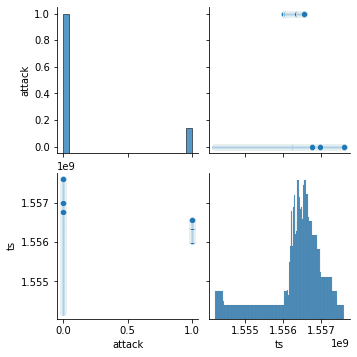

In [9]:
import seaborn as sns
cols = ['attack','ts']
sns.pairplot(processDF_Sample_Num[cols])

<p><strong style="color:#2a52be"> For Process activity, again down sampling to only 60% of the data it can be seen that the timestamp is more concentrated on the later time of over 1.556. And number of attacks done during the 1.556 and 1.557 account to attacks taken place which is significantly less than the normal records. There is a visible imbalance. </strong>

### Correlation Matrix for Feature Correlation Analysis :

<AxesSubplot:>

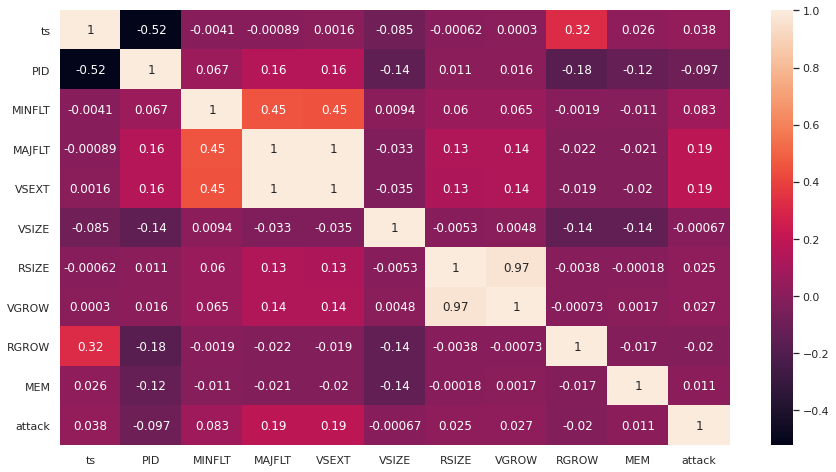

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
 
plt.figure(figsize=(15,8))
sns.heatmap(memoryDF_Sample.corr(),annot=True)

<p><strong style="color:#2a52be"> There is a high correlation VSEXT and MAJFLT & VGROW and RSIZE. And a high negative correlation between ts and PID. A negative correlation is shown between ts and PID that move consistently in opposite directions. So potentially one will have an influence on the other, so a change in one of value can significantly affect the other. Hence one of these features needs to be removed. </strong>

<AxesSubplot:>

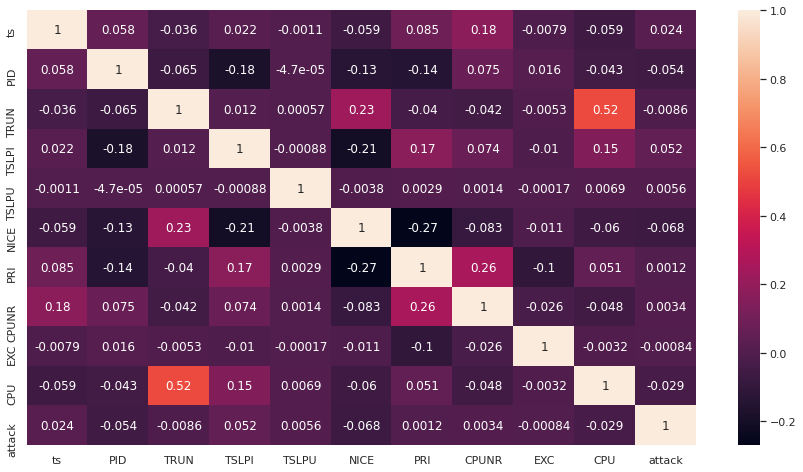

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
 
plt.figure(figsize=(15,8))
sns.heatmap(processDF_Sample_Num.corr(),annot=True)

<p><strong style="color:#2a52be"> There is a high correlation between CPU and TRUN. So potentially one will have an influence on the other, so a change in one of value can significantly affect the other. Hence one of these features needs to be removed. </strong>

## 2. Feature extraction and ML training (55%)


### 2.1 Preparing the training data and testing data (4%)

#### 1. Randomly split the dataset into 80% training data and 20% testing data for each use case

In [28]:
# Randomly split the data in 80:20 ratio for training and testing data
train_memory, test_memory = memoryDF.randomSplit([0.8, 0.2], seed=2020)
train_process, test_process = processDF.randomSplit([0.8,0.2], seed = 2020)

#### Split the training data again using only 20% of the initial 80% training data

In [29]:
# Split the training data again using only 20% of the initial 80% training data
train_memory_required, test_nt_memory = train_memory.randomSplit([0.2, 0.8], seed=2020)
train_process_required, test__nt_process = train_process.randomSplit([0.2,0.8], seed = 2020)

<p><strong style="color:#2a52be"> Downsampling the data to reduce the imbalance between the two outcome classes. This will significantly improve the model predictions, as bias would be removed.  </strong>

In [30]:
#Downsampling the data to have attack and non attack events in 1:2 ratio.
def downsample(features, ratio, class_field, base_class):
    pos = features.filter(col(class_field) == base_class)
    neg = features.filter(col(class_field) != base_class)
    total_pos = pos.count()
    total_neg = neg.count()
    fraction = float(total_pos * ratio) / float(total_neg)
    sampled = neg.sample(False, fraction)
    return sampled.union(pos)

#Rebalancing the data
rebalanced_memory = downsample(train_memory_required, 2, 'attack' ,1)
rebalanced_memory = rebalanced_memory.cache()

#Rebalancing the data
rebalanced_process = downsample(train_process_required, 2, 'attack' ,1)
rebalanced_process = rebalanced_process.cache()


In [31]:
#Checking counts for the rebalanced data
rebalanced_memory.groupBy('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|32738|
|     0|65254|
+------+-----+



In [32]:
#Checking counts for the rebalanced data
rebalanced_process.groupBy('attack').count().show()

+------+-----+
|attack|count|
+------+-----+
|     1|46536|
|     0|93020|
+------+-----+



## 2.2 Preparing features, labels and models (16%)
### 1. Based on data exploration from 1.3.3, which features would you select? Discuss the reason for selecting them and how you plan to further transform them.


In [20]:
memoryDF.select("ts").distinct().count()

1263459

In [21]:
memoryDF.select("PID").distinct().count()

14966

In [22]:
processDF.select("PID").distinct().count()

20949

In [23]:
processDF.select("ts").distinct().count()

1315076

<p><strong style="color:#2a52be"> 

    From the correlation matrix it can be seen that the correlation between ts and PID is a high negative correlation. Hence, one of the two features need to be removed as any change in one of the variables will influence the other. Also, another major factor in removal of ts as a feature is the count of the distinct values in the data. In a data of 20L, close to 12L values are unique and wouldn’t serve a purpose in predicting accurately, as this may lead to over fitting. One possible way to use this further, would be to look for trends in a particular month or date. Rather than the time period. VSTEXT and MAJFLT, also have a high positive correlation. One of the features that I do not continue to consider as a feature is VSTEXT, as shared text memory for a memory can also be derived from VSIZE. And this may add to redundancy. MAJFLT is a better feature when it comes to this use case’s prediction. PID however unique, 14966 values of 20L records, has a certain trend of repetition, which will help the process based on the CMD column for interval limits. Hence, retaining PID for this model. All the other numeric (MEM, VSIZE, RSIZE, RGROW, VGROW, MINFLT, MAJFLT) and string columns (CMD) are vital for the model’s prediction. 

    For the process activity, ts again has 13L unique records in a set of 19L records. Eliminating this feature would not lead to over fitted data. Also, TRUN and CPU are highly correlated. So, the use of TRUN is redundant when it comes to the State column because for 0 running threads in TRUN, the state can have any states, but for threads greater than 1, the states of the TRUN are always R,S which is indicated by the other two columns, TSLPI and TSLPU. 
    
For the transformers, the categorical data columns needs to be passed through the string Indexer stage as different Indexes needs to be created for it. The Indexed data will then be passed to the One hot Encoder stage where in the indexed values will be transformed to binary output. Then using the Vector Indexer, all the input features will be combined to one vector feature. Using the Min-Max Scaler, the features are all on the same relative scale. The relative spaces between each feature’s values have been maintained. $.^{[6]} $


In [11]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

## Model for the Memory activity based on Decision Tree Classifier :

In [33]:
##MEMORY DECISION TREE

# First, save the category in the category columns list.
categoryInputCols = ['CMD']
numericInputCols = ['VGROW','RGROW' ,'VSIZE','RSIZE','PID','MINFLT','MAJFLT','MEM']

#Target Column
categoryOutputCol = ['attack']

categoryCols = categoryInputCols+categoryOutputCol

outputCols=[f'{x}_index' for x in categoryInputCols]
#Adding label to the output columns
outputCols.append('label')

#Adding an handler to handle unseen labels in the test data
inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols).setHandleInvalid("keep")

#Defining OneHotEncoder with the appropriate columns
inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

#Defining VectorAssembler with the appropriate columns
inputCols=outputCols_OHE
assemblerInputs = outputCols_OHE + numericInputCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

#Defining MinMaxScaler with the appropriate columns
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")

#Defining DecisionTreeClassifier with the appropriate columns
dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'label')

#Assigning stages order 
stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_4 = scaler
stage_5 = dt

stages = [stage_1,stage_2,stage_3,stage_4,stage_5]

#Setting the Pipeline 
pipeline_mem_model1 = Pipeline(stages = stages)

#Use the fit method to train the model with the training data
pipelineModel_memory_model1 = pipeline_mem_model1.fit(rebalanced_memory)

#predictions_memory_model1 = pipelineModel_memory_model1.transform(test_memory)

<h2> Model for the Memory activity based on Gradient Boosted Tree Classifier :

In [34]:
##MEMORY GBT TREE

# First, save the category in the category columns list.
categoryInputCols = ['CMD']
numericInputCols = ['VGROW','RGROW' ,'VSIZE','RSIZE','PID','MINFLT','MAJFLT','MEM']

#Target Column
categoryOutputCol = ['attack']

categoryCols = categoryInputCols+categoryOutputCol

outputCols=[f'{x}_index' for x in categoryInputCols]
#Adding label to the output columns
outputCols.append('label')

#Adding an handler to handle unseen labels in the test data
inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols).setHandleInvalid("keep")

#Defining OneHotEncoder with the appropriate columns
inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

#Defining VectorAssembler with the appropriate columns
inputCols=outputCols_OHE
assemblerInputs = outputCols_OHE + numericInputCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

#Defining MinMaxScaler with the appropriate columns
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")

#Defining GBTClassifier with the appropriate columns
classifier = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

#Assigning stages order 
stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_4 = scaler
stage_5 = classifier

stages = [stage_1,stage_2,stage_3,stage_4,stage_5]

#Setting the Pipeline 
pipeline_mem_model2 = Pipeline(stages = stages)

#Use the fit method to train the model with the training data
pipelineModel_memory_model2 = pipeline_mem_model2.fit(rebalanced_memory)

#predictions_memory_model2 = pipelineModel_memory_model2.transform(test_memory)

<h2> Model for the Process activity based on Decision Tree Classifier :

In [35]:
# First, save the category in the category columns list.
categoryInputCols = [ 'Status','CMD','State','POLI']
numericInputCols = ['PID','NICE','PRI','CPUNR','EXC','TSLPI','TSLPU','EXC']
#['PID','NICE','PRI','CPU','CPUNR','EXC']['PID','TRUN','TSLPU','CPU','NICE']

#Target Column
categoryOutputCol = ['attack']

categoryCols = categoryInputCols +categoryOutputCol

outputCols=[f'{x}_index' for x in categoryInputCols]
#Adding label to the output columns
outputCols.append('label')

#Adding an handler to handle unseen labels in the test data
inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols).setHandleInvalid("keep")

#Defining OneHotEncoder with the appropriate columns
inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

#Defining VectorAssembler with the appropriate columns
inputCols=outputCols_OHE
assemblerInputs = outputCols_OHE + numericInputCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

#Defining MinMaxScaler with the appropriate columns
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")

#Defining DecisionTreeClassifier with the appropriate columns
dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'label')

#Assigning stages order 
stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_4 = scaler
stage_5 = dt

stages = [stage_1,stage_2,stage_3,stage_4, stage_5]

#Setting the Pipeline 
pipeline_process_model1 = Pipeline(stages = stages)

#Use the fit method to train the model with the training data
pipelineModel_process_model1 = pipeline_process_model1.fit(rebalanced_process)

#predictions_process_model1 = pipelineModel_memory_model1.transform(test_process)

<h2> Model for the Process activity based on Gradient Boosted Tree Classifier :


In [36]:
# First, save the category in the category columns list
categoryInputCols = ['POLI' , 'Status', 'State', 'CMD']
numericInputCols = ['PID','TSLPI','TSLPU','NICE','PRI','CPUNR','EXC','CPU']

#Target Column
categoryOutputCol = ['attack']

categoryCols = categoryInputCols+categoryOutputCol

#train, test = df.randomSplit([0.7, 0.3], seed = 2020)

outputCols=[f'{x}_index' for x in categoryInputCols]
#Adding label to the output columns
outputCols.append('label')

#Adding an handler to handle unseen labels in the test data
inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols).setHandleInvalid("keep")

#Defining OneHotEncoder with the appropriate columns
inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

#Defining VectorAssembler with the appropriate columns
inputCols=outputCols_OHE
assemblerInputs = outputCols_OHE + numericInputCols
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

#Defining MinMaxScaler with the appropriate columns
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaledFeatures")

#Defining GBTClassifier with the appropriate columns
classifier = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

#Assigning stages order 
stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler
stage_4 = scaler
stage_5 = classifier

stages = [stage_1,stage_2,stage_3,stage_4,stage_5]

#Setting the Pipeline 
pipeline_process_model2 = Pipeline(stages = stages)

#Use the fit method to train the model with the training data
pipelineModel_process_model2 = pipeline_process_model2.fit(rebalanced_process)

#predictions_process_model2 = pipelineModel_process_model2.transform(test_process)

## 2.3 Training and evaluating models (35%)

### 1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2

In [37]:
#Here we use the model trained with the training data to give predictions for our test data
predictions_memory_model1 = pipelineModel_memory_model1.transform(test_memory)
predictions_memory_model2 = pipelineModel_memory_model2.transform(test_memory)
predictions_process_model1 = pipelineModel_process_model1.transform(test_process)
predictions_process_model2 = pipelineModel_process_model2.transform(test_process)

### 2. For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label

In [38]:
# Displaying the prediction and the actual label count for each of the combinations

print("Decision Tree Memory Model 1")
mem_model1 = predictions_memory_model1.groupby("prediction","label").count()
mem_model1.show()

print("Gradient Boosted Tree Memory Model 1")
mem_model2 = predictions_memory_model2.groupby("prediction","label").count()
mem_model2.show()

print("DecisionTree Process Model 1")
proc_model1 = predictions_process_model1.groupby("prediction","label").count()
proc_model1.show()

print("Gradient Boosted Tree Process Model 2")
proc_model2 = predictions_process_model1.groupby("prediction","label").count()
proc_model2.show()


Decision Tree Memory Model 1
+----------+-----+------+
|prediction|label| count|
+----------+-----+------+
|       1.0|  1.0| 25858|
|       0.0|  1.0| 15400|
|       1.0|  0.0| 77299|
|       0.0|  0.0|281241|
+----------+-----+------+

Gradient Boosted Tree Memory Model 1
+----------+-----+------+
|prediction|label| count|
+----------+-----+------+
|       1.0|  1.0| 17579|
|       0.0|  1.0| 23679|
|       1.0|  0.0| 33976|
|       0.0|  0.0|324564|
+----------+-----+------+

DecisionTree Process Model 1
+----------+-----+------+
|prediction|label| count|
+----------+-----+------+
|       1.0|  1.0| 28406|
|       0.0|  1.0| 29974|
|       1.0|  0.0| 46013|
|       0.0|  0.0|281063|
+----------+-----+------+

Gradient Boosted Tree Process Model 2
+----------+-----+------+
|prediction|label| count|
+----------+-----+------+
|       1.0|  1.0| 28406|
|       0.0|  1.0| 29974|
|       1.0|  0.0| 46013|
|       0.0|  0.0|281063|
+----------+-----+------+



### 3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.
 

<p><strong style="color:#2a52be"> 
        Classification Metrics for imbalanced data varies from that for balanced class data, when the samples of one class in a dataset outnumber the samples of the other class. The class distribution is the ratio of the positive and negative samples in the data, represented by the left and right columns of the confusion matrix. Any performance metric that relies on the use of values from both the columns will be sensitive if an imbalanced data is presented. So accuracy and precision would be affected as data distribution changes, these metrics will change even if the classifier performance does not. ROC Curves are robust against any changes to class distributions. Hence, if the ratio  of positive to negative samples changes in a test set, the ROC curve will not change. This is because ROC depends on TPR and FPR, and each of them is a columnar ratio. Comparing different classifiers in the ROC curve is not easy. This is because there is no scalar value represents the expected performance. Therefore, the Area under the ROC curve (AUC) metric is used to calculate the area under the ROC curve. Also recall is is the most useful when we want the model to pick as many as
positive samples from actual positives. Hence, both recall and AUC are better metrics than the rest for the model performance $.^{[2]}$  </strong>

- **Accuracy:** Out of all the classes, how much we predicted correctly. It should be high as possible.
- **Precision:** Out of all the positive classes we have predicted correctly, how many are actually positive.
- **Recall:** Out of all the positive classes, how much we predicted correctly. It should be high as possible.


In [19]:
from pyspark.mllib.evaluation import MulticlassMetrics

#Metrics calculation using the MulticlassMetrics

def compute_metrics(predictions):
    predictions_labels = predictions.select('prediction', 'label')
    metrics = MulticlassMetrics(predictions_labels.rdd)
    
    #Calculating the metrics
    accuracy =  metrics.accuracy
    precision = metrics.precision(label = 1)
    recall = metrics.recall(label = 1)

    print("Summary Stats For the Model")
    print("Accuracy = %g " % accuracy)
    print("Precision = %g " % precision)
    print("Recall = %g " % recall)


In [39]:
print("The Metrics for Model Performance for Memory Model 1: \n")
mem_model1 = compute_metrics(predictions_memory_model1)
mem_model1

print("\n The Metrics for Model Performance for Memory Model 2: \n")
mem_model2 = compute_metrics(predictions_memory_model2)
mem_model2

print("\n The Metrics for Model Performance for Process Model 1: \n")
proc_model1 = compute_metrics(predictions_process_model1)
proc_model1

print("\n The Metrics for Model Performance for Process Model 2: \n")
proc_model2 = compute_metrics(predictions_process_model2)
proc_model2

The Metrics for Model Performance for Memory Model 1: 

Summary Stats For the Model
Accuracy = 0.768135 
Precision = 0.250666 
Recall = 0.626739 

 The Metrics for Model Performance for Memory Model 2: 

Summary Stats For the Model
Accuracy = 0.85579 
Precision = 0.340976 
Recall = 0.426075 

 The Metrics for Model Performance for Process Model 1: 

Summary Stats For the Model
Accuracy = 0.802865 
Precision = 0.381704 
Recall = 0.486571 

 The Metrics for Model Performance for Process Model 2: 

Summary Stats For the Model
Accuracy = 0.803264 
Precision = 0.388238 
Recall = 0.519253 


### AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.


In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Calculation the Area Under the curve for ROC 

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC AUC for Memory Model 1 : " + str(evaluator.evaluate(predictions_memory_model1, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under ROC AUC for Memory Model 2 : " + str(evaluator.evaluate(predictions_memory_model2, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under ROC AUC for Process Model 1 : " + str(evaluator.evaluate(predictions_process_model1, {evaluator.metricName: "areaUnderROC"})))
print("Test Area Under ROC AUC for Process Model 2 : " + str(evaluator.evaluate(predictions_process_model2, {evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC AUC for Memory Model 1 : 0.6106397212516579
Test Area Under ROC AUC for Memory Model 2 : 0.8274974630092007
Test Area Under ROC AUC for Process Model 1 : 0.575135681415436
Test Area Under ROC AUC for Process Model 2 : 0.8060859279793919


### Display the top-5 most important features in each model. Discuss which pipeline model is better, and whether the feature “ts” should be included in the model . 

### And visualise the ROC curve for the better model you selected for each use case

<p><strong style="color:#2a52be"> GBT is better when it comes to comparing it with Decision Tree classifier, as Gradient Boosting performs well when you have unbalanced data such as in real time risk assessment. Decision trees have high variance, which means that tiny changes in the training data have the potential to cause large changes in the final result. Gradient Boosting trains many models in a gradual, additive and sequential manner.  
A single decision tree is a weak predictor, but is relatively fast to build. More trees give you a more robust model and prevent overfitting. However, the more trees you have, the slower the process. GBT grows decision trees one after another guided by a mechanism called ‘boosting’ $.^{[3]}$ 
    
    Based on the metrics, AUC was greater for the GBT models for both the activities. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate 
Cross validation and hyper tuning can further increase the optimization and help in finding the best model as you can limit the iteration for which the model stops improving the prediction results. 
    
    
Including ts would lead to over fitting as the number of unique values for ts is very high to predict any trends. So it would be suitable to eliminate this feature. Also, another major factor in removal of ts as a feature is the count of the distinct values in the data. In a data of 20L, close to 12L values are unique and wouldn’t serve a purpose in predicting accurately, as this may lead to over fitting. 'ts' overshadows the effect of other features in the model with it's high feature imortance score. One possible way to use this further, would be to look for trends in a particular month or date. Rather than the time period. Also the accuracy and feature importance of the model shoots up when ts is included as an indication of over fitted model. Timestamp would be an important feature for exploratory analysis such as Time-based analysis to predict at which hour of the day did the attack take place. 
    </strong>


In [41]:
# Creating the Features Score for each feature in the features column [7]

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    #print(varlist)
    return(varlist.sort_values('score', ascending = False))

In [42]:
import pandas as pd

def compute_important_features(pipeline_model, prediction_test):
    imp = pipeline_model.stages[-1].featureImportances
    features_with_score = ExtractFeatureImp(imp, prediction_test, "features").head(5)
    return features_with_score

In [43]:
print("The important features for the Memory Model 1")
compute_important_features(pipelineModel_memory_model1,predictions_memory_model1)

The important features for the Memory Model 1


,idx,name,score
4,433,PID,0.299253
9,1,CMD_vec_apache2,0.253695
1,430,RGROW,0.125129
3,432,RSIZE,0.103231
5,434,MINFLT,0.094937


In [44]:
print("The important features for the Memory Model 2")
compute_important_features(pipelineModel_memory_model2,predictions_memory_model2)

The important features for the Memory Model 2


,idx,name,score
4,433,PID,0.377483
5,434,MINFLT,0.157323
2,431,VSIZE,0.150433
3,432,RSIZE,0.126281
9,1,CMD_vec_apache2,0.043877


In [45]:
print("The important features for the Process Model 1")
compute_important_features(pipelineModel_process_model1,predictions_process_model1)

The important features for the Process Model 1


,idx,name,score
0,448,PID,0.476329
8,0,Status_vec_-,0.344230
5,453,TSLPI,0.059141
454,446,POLI_vec_0,0.046147
1,449,NICE,0.044461


In [46]:
print("The important features for the Process Model 2")
compute_important_features(pipelineModel_process_model2,predictions_process_model2)

The important features for the Process Model 2


,idx,name,score
0,448,PID,0.416402
11,3,Status_vec_-,0.076389
5,453,CPUNR,0.052389
41,33,CMD_vec_tcpdump,0.052117
23,15,CMD_vec_apache2,0.041336


### Displaying the ROC Curve for the better model in both the activities.

In [27]:
import numpy as np
# Setting a threshold to calculate the different TPR AND FPR values for the ROC Curve
threshold = np.linspace(0, 1, 15)

In [28]:
# Creating the confusion matrix

#Confusion Matrix is a performance measurement for machine learning classification problem where output can be two or more classes. 
#It is a table with 4 different combinations of predicted and actual values where T/F refers to true and positive respectively.
# and P/N to positive and negative respectively.

def confusion_matrix(predictions):
    # Calculate the elements of the confusion matrix
    predictions = predictions.groupby('prediction','label').count() 
    TN = predictions.filter('prediction = 0 AND label = 0').select('count').collect()[0][0]
    TP = predictions.filter('prediction = 1 AND label = 1').select('count').collect()[0][0]
    FN = predictions.filter('prediction = 0 AND label = 1').select('count').collect()[0][0]
    FP = predictions.filter('prediction = 1 AND label = 0').select('count').collect()[0][0]
    return TP,TN,FP,FN

In [29]:
def confusion_matrix(predictions):
     # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = 0').count()
    TP = predictions.filter('prediction = 1 AND label = 1').count()
    FN = predictions.filter('prediction = 0 AND label = 1').count()
    FP = predictions.filter('prediction = 1 AND label = 0').count()
    return TP,TN,FP,FN

In [30]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Function to create the ROC curve for the better models of the activities 

def roc_curve(model,threshold):
    #User Defined Function to split the probabilities into two columns
    to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
    df = model.withColumn('probability', to_array('probability')) #Splitting the probability to 2 parts using the UDF
    #A new df which contains the probabilites in separate columns
    prob_df = df.select(df.probability[0].alias('negative_prob'),df.probability[1].alias('positive_prob'),'label')
    tpr_list = []
    fpr_list = []
    for i in threshold:
        test_df=prob_df.withColumn('prediction',F.when(prob_df.positive_prob > i,1).otherwise(0))
        tp,tn,fp,fn = confusion_matrix(test_df)  
        tpr = tp/(tp+fn)
        tpr_list.append(tpr) #Adding each value to the list for plotting
        fpr = fp/(fp+tn) 
        fpr_list.append(fpr) #Adding each value to the list for plotting
        print('TPR:',tpr,'FPR:',fpr,'threshold' ,i)
    return tpr_list,fpr_list

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

#Plotting the ROC Curve using Matplotlib
def plot_roc(tpr,fpr): 
    plt.plot(fpr,tpr)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC Curve')
    plt.show()
    

In [32]:
tpr_list, fpr_list = roc_curve(predictions_memory_model2,threshold)

TPR: 1.0 FPR: 1.0 threshold 0.0
TPR: 0.999975762276407 FPR: 0.9999916327327495 threshold 0.07142857142857142
TPR: 0.9960007756071549 FPR: 0.6926395939086294 threshold 0.14285714285714285
TPR: 0.9579717872897378 FPR: 0.5765911753221398 threshold 0.21428571428571427
TPR: 0.7946337679965098 FPR: 0.29415685837005634 threshold 0.2857142857142857
TPR: 0.7794367153036986 FPR: 0.2589446086908016 threshold 0.3571428571428571
TPR: 0.6848853555674052 FPR: 0.2111479890667708 threshold 0.42857142857142855
TPR: 0.4181249697028455 FPR: 0.08519551514475372 threshold 0.5
TPR: 0.335959086722575 FPR: 0.05676911920566743 threshold 0.5714285714285714
TPR: 0.21021377672209027 FPR: 0.02390528253472416 threshold 0.6428571428571428
TPR: 0.12576954772407775 FPR: 0.008211078261839684 threshold 0.7142857142857142
TPR: 0.06304231906539338 FPR: 0.0016483516483516484 threshold 0.7857142857142857
TPR: 0.04362790246740026 FPR: 0.00023428348301444748 threshold 0.8571428571428571
TPR: 0.019729507004702117 FPR: 2.2312712

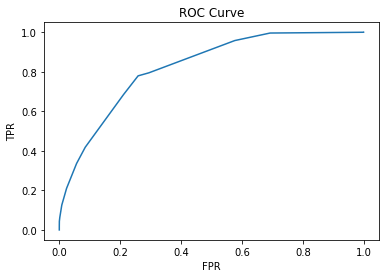

In [33]:
plot_roc(tpr_list ,fpr_list )

In [34]:
tpr_list, fpr_list = roc_curve(predictions_process_model2,threshold)

TPR: 1.0 FPR: 1.0 threshold 0.0
TPR: 1.0 FPR: 0.999960253885947 threshold 0.07142857142857142
TPR: 0.9970537855429942 FPR: 0.7762477222419254 threshold 0.14285714285714285
TPR: 0.9541966426858514 FPR: 0.571775367192946 threshold 0.21428571428571427
TPR: 0.8083932853717026 FPR: 0.3798230380706625 threshold 0.2857142857142857
TPR: 0.6927886262418637 FPR: 0.2563716078220352 threshold 0.3571428571428571
TPR: 0.635423090099349 FPR: 0.21396250412748108 threshold 0.42857142857142855
TPR: 0.4789140116478246 FPR: 0.12470496153799117 threshold 0.5
TPR: 0.3878211716341213 FPR: 0.08851765338942631 threshold 0.5714285714285714
TPR: 0.18888317917094896 FPR: 0.03319412002103487 threshold 0.6428571428571428
TPR: 0.06606714628297362 FPR: 0.008890899974317896 threshold 0.7142857142857142
TPR: 0.001815690304898938 FPR: 0.00014981227604593427 threshold 0.7857142857142857
TPR: 1.7129153819801302e-05 FPR: 3.057393388692536e-06 threshold 0.8571428571428571
TPR: 0.0 FPR: 0.0 threshold 0.9285714285714285
TPR: 

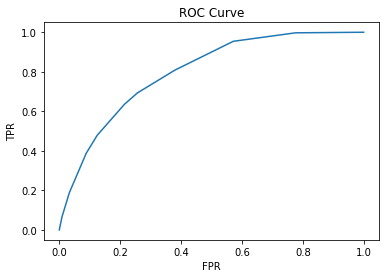

In [35]:
plot_roc(tpr_list ,fpr_list )

### Using the pipeline model you selected in the previous step, re-train the pipeline model using a bigger set of rebalanced training data, with attack events and non-attack events being 1:2 ratio, while using all attack events data from the full data for both use cases. Then persist the better models for each use case.


In [34]:
#FROM 2.1.2 Reusing the downsample function on the initial split

#Rebalancing the data
rebalanced_memory = downsample(train_memory, 2, 'attack' ,1)
rebalanced_memory = rebalanced_memory.cache()

#Rebalancing the data
rebalanced_process = downsample(train_process, 2, 'attack' ,1)
rebalanced_process = rebalanced_process.cache()

In [32]:
rebalanced_memory.groupBy('attack').count().show()

+------+------+
|attack| count|
+------+------+
|     1|164365|
|     0|329050|
+------+------+



In [33]:
rebalanced_process.groupBy('attack').count().show()

+------+------+
|attack| count|
+------+------+
|     1|232984|
|     0|466458|
+------+------+



In [35]:
#Use the fit method to train the model with the training data

pipelineModel_memory_model2 = pipeline_mem_model2.fit(rebalanced_memory)
pipelineModel_process_model2 = pipeline_process_model2.fit(rebalanced_process)

#Here we use the model trained with the training data to give predictions for our test data
predictions_memory_model2 = pipelineModel_memory_model2.transform(test_memory)
predictions_process_model2 = pipelineModel_process_model2.transform(test_process)

### <p><strong style="color:#2a52be"> Based on the AUC and ROC metric the GBT models performed better for both the use cases. 

In [36]:
#Persisting and saving the model to the filesystem
pipelineModel_memory_model2.save('final_memory_model')
pipelineModel_process_model2.save('final_process_model')

## 3. Knowledge sharing (10%)

In [64]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, IndexToString
from pyspark.ml.clustering import KMeans

iris_df = spark.createDataFrame([
(4.7, 3.2, 1.3, 0.2),
(4.9, 3.1, 1.5, 0.1),
(5.4, 3.9, 1.3, 0.4),
(5.0, 3.4, 1.6, 0.4),
(5.1, 3.8, 1.6, 0.2),
(4.9, 2.4, 3.3, 1.0),
(6.6, 2.9, 4.6, 1.3),
(5.6, 3.0, 4.5, 1.5),
(5.7, 2.6, 3.5, 1.0),
(5.8, 2.6, 4.0, 1.2),
(5.8, 2.8, 5.1, 2.4),
(6.2, 2.8, 4.8, 1.8),
(6.0, 3.0, 4.8, 1.8),
(6.7, 3.1, 5.6, 2.4),
(6.7, 3.0, 5.2, 2.3),
(6.2, 3.4, 5.4, 2.3)],
['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

assembler = VectorAssembler(
inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
outputCol='features')

kmeans = KMeans(k=3).fit(assembler.transform(iris_df))

centers = kmeans.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[5.82857143 2.75714286 4.21428571 1.37142857]
[5.02 3.48 1.46 0.26]
[6.35  3.075 5.325 2.35 ]


## <p><strong style="color:#2a52be"> As seen from the spark UI, 10 jobs have been observed for the K-means clustering. </strong>

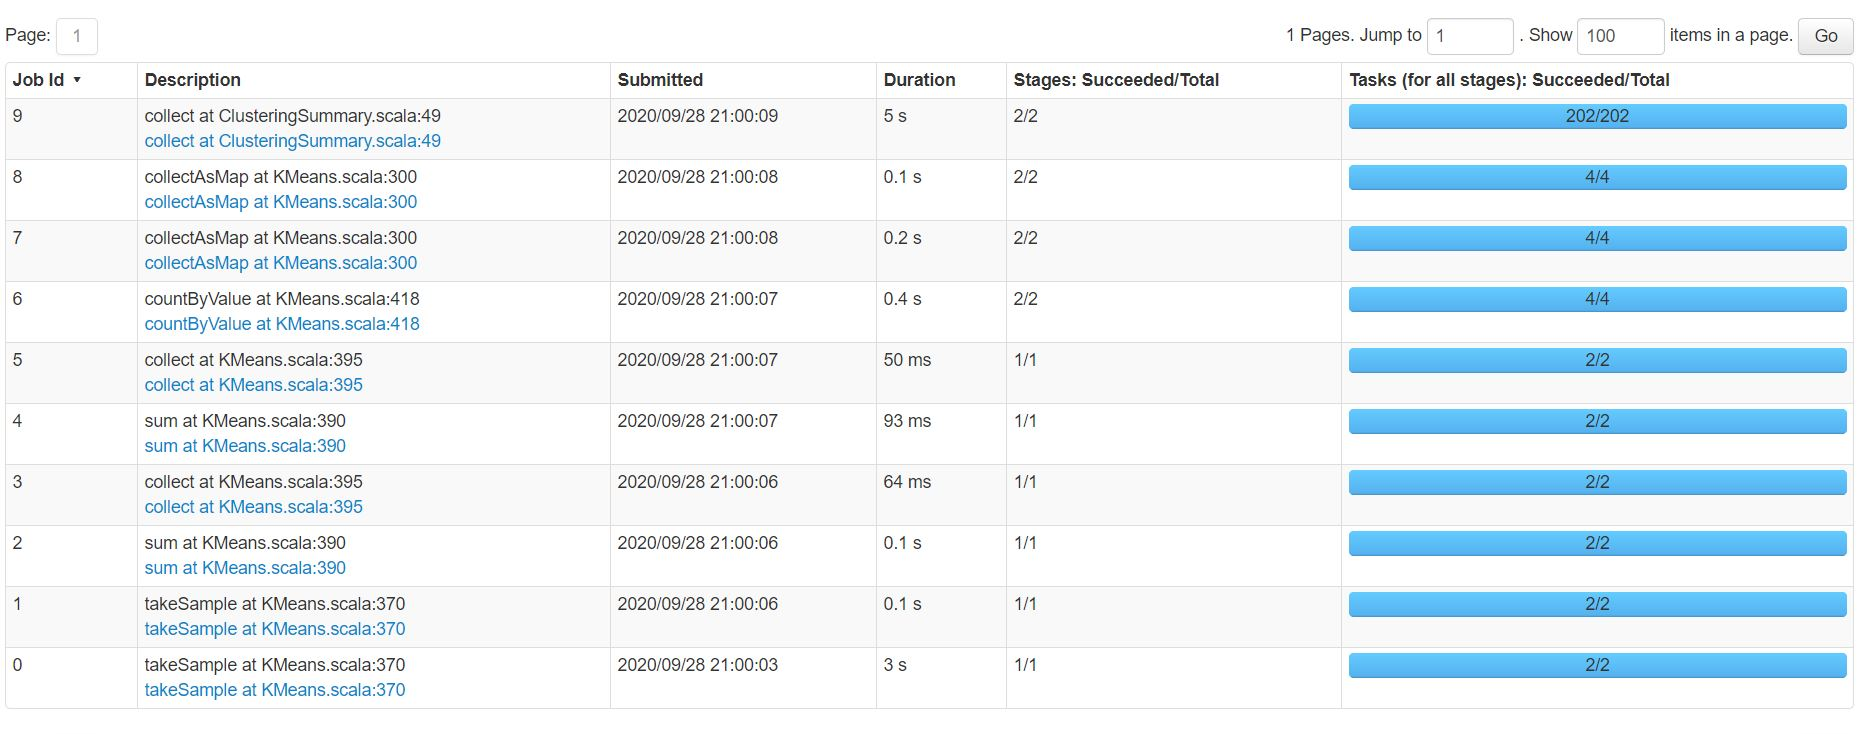

<p><strong style="color:#2a52be"> K-means is an Unsupervised Clustering Algorithm. It's key measure is the degree of similarity between the two objects. The shorter the Euclidean distance between the two objects the more the similarity between the objects. To summarize the K-Means algorithm, the algorithm specifies k number of clusters, and the k seed cluster centroid is then guessed. It then iteratively checks for each data points and assigns the data point to the closest centroid. And in the case of re-iteration because of the loss of data points to other clusters and addition of new members coming from other clusters. Each cluster will then have to recalculate the centroid. This process is repeated until the cluster is converged or membership composition is reached and fixed number of iterations have been performed. 
    
Applying this to the stages seen in Spark,  K-means is a partional clustering algorithm. In stage 1, the k-mean init is initialized with k, and distance measure as well as the initialization steps which is by default 5. Data is read as an instance of rdd from the vector features provided to K-means. And initially seed is created to maintain the points constants for the whole iteration between the clusters. Initial cluster centers are made using random and then by k-means Hence, the In stage 3, the centers from the average vector is calculated, else the vector costs are summed to find the mean. And new center points are calculated. And at the next stage, the data is calculated again with new center lists of the vectors, i.e. in each iteration, the distance between each data point and the new centroid needs to be calculated. And the minimum distance between the new data centers are calculated with the points and persisted. This is then collected in the next step as the chosen data with the costs zipped along. And new centers for this data is calculated for the next trial. 
    
At stage 6, when k distinct centers have been found, these distinct centers will be persisted. And then each Individual point is then evaluated against the centers and the closest distance to the center. And the best center for that point is updated. And in stage 8 & 7 each centroid is grouped against the data points to form clusters and the converged flag is then turned to true. This process is repeated until the cluster is converged and fixed number of iterations have been performed. And finally the clustering is summarized to output the final clusters.

 </strong>

### References: 

1. Kumar, S.; Chong, I. Correlation Analysis to Identify the Effective Data in Machine Learning: Prediction of Depressive Disorder and Emotion States. Int. J. Environ. Res. Public Health 2018, 15, 2907
2. Alaa Tharwat, Classification assessment methods, Applied Computing and Informatics, 2018,ISSN 2210-8327
3.  Sikha Bagui, Xingang Fang, Ezhil Kalaimannan, Subhash C. Bagui & Joseph Sheehan (2017) Comparison of machine-learning algorithms for classification of VPN network traffic flow using time-related features, Journal of Cyber Security Technology, 1:2, 108-126 
4. https://github.com/elsyifa/Classification-Pyspark
5. https://spark.apache.org/docs/2.3.0/ml-classification-regression.html
6. https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/
7. https://sebastianraschka.com/Articles/2014_about_feature_scaling.html
8. https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
9. https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
10. https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html